In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import whitw
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
import pandas as pd
import math
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
from timer import Timer
import os

In [2]:
alpha = 0
beta = 25
Mpl = 1.

In [3]:
def ModeEoM(A, k, dphidt, dIdphi, a, sigmaE=0, sigmaB=0):
    #omega=1.
    dAdt = np.zeros(A.size)

    drag = a**(-alpha) * sigmaE
    dis1 = k * a**(alpha-1)
    dis2 = dIdphi * dphidt + a**(alpha)*sigmaB

    #positive helicity
    lam = 1.
    #Real Part
    dAdt[0] = A[1]*(k/a)*a**(alpha)
    dAdt[1] = -( drag * A[1] + (dis1  - lam * dis2) * A[0] )
    
    #Imaginary Part
    dAdt[2] = A[3]*(k/a)*a**(alpha)
    dAdt[3] = -( drag * A[3] + (dis1  - lam * dis2) * A[2] )
    
    
    #negative helicity
    lam = -1.
    #Real Part
    dAdt[4] = A[5]*(k/a)*a**(alpha)
    dAdt[5] = -( drag * A[5] + (dis1  - lam * dis2) * A[4] )
    
    #Imaginary Part
    dAdt[6] = A[7]*(k/a)*a**(alpha)
    dAdt[7] = -( drag * A[7] + (dis1  - lam * dis2) * A[6] )
    
    return dAdt

In [20]:
def ModeByMode(tmin, tmax, tend, kh, dphidt, dIdphi, a, steps=100, cut=0.1,
               sigmaE=None, sigmaB=None, delta=1., save=False):
    dt = (tmax-tmin)/(steps)
    ts = np.arange(tmin, tend, dt)
    
    if sigmaE==None:
        sigmaE = lambda x: 0.
        delta = lambda x: 1.
    if sigmaB==None:
        sigmaB = lambda x: 0.
        
    Ap = []
    dApdt = []
    Am = []
    dAmdt = []
    ks = []
    t2 = Timer()
    t2.start()
    for i in range(1,steps):
        s = ts[i]
        if (kh(s)/kh(ts[i-1]) > cut): 
            k = 10**(5/2)*kh(s)

            #t1 = Timer()
            ks.append(k)
        
            #t1.start()
            Aini = np.array([1., 0, -1/2*sigmaE(s)/k, -1., 1, 0, -1/2*sigmaE(s)/k, -1.])*np.sqrt(delta(s))
            ode = lambda x, y: ModeEoM(y, k, dphidt(x), dIdphi, a(x), sigmaE=sigmaE(x), sigmaB=sigmaB(x))
            
            sol = solve_ivp(ode, [s, ts[-1]], Aini, t_eval=ts[i:], method="RK45", atol=1e-8, rtol=1e-8)
            
            #vacuum will not contribute to integrals, so we set this part to 0 to have equal length arrays
            vac = list((1+0j)*np.ones((i)))
            dvacdt = list((0.-1j)*np.ones((i)))
            
            Aptmp = list(np.array(sol.y[0,:]) + np.array(sol.y[2,:])*1j)
            Ap.append([*vac, *Aptmp])
            
            dAptmp = list(np.array(sol.y[1,:]) + np.array(sol.y[3,:])*1j)
            dApdt.append([*dvacdt, *dAptmp])
            
            
            Amtmp = list(np.array(sol.y[4,:]) + np.array(sol.y[6,:])*1j)
            Am.append([*vac, *Amtmp])
            
            dAmtmp = list(np.array(sol.y[5,:]) + np.array(sol.y[7,:])*1j)
            dAmdt.append([*dvacdt, *dAmtmp])

            #t1.stop()
        else:
            print("skip")
            continue
            
    Ap = np.array(Ap)
    dApdt = np.array(dApdt)            
    Am = np.array(Am)
    dAmdt = np.array(dAmdt)
    
    t2.stop()
    
    if save:
        SaveMode(ts, ks, Ap, dApdt, Am, dAmdt, af)
                   
    
    return Ap, dApdt, Am, dAmdt, ks, ts

In [21]:
def SaveMode(t, k, Ap, dAp, Am, dAm, af, name=None):
    logk = np.log10(k)
    N = list(np.log(af(t)))
    N = np.array([np.nan]+N)
    t = np.array([np.nan]+list(t))
    dic = {"t":t}
    dic = dict(dic, **{"N":N})
    for k in range(0, len(Ap[:,0])):
        dictmp = {"Ap_" + str(k) :np.array([logk[k]] + list(Ap[k,:]))}
        dic = dict(dic, **dictmp)
        dictmp = {"Am_" + str(k) :np.array([logk[k]] + list(dAp[k,:]))}
        dic = dict(dic, **dictmp)
        dictmp = {"dAp_" + str(k):np.array([logk[k]] + list(Am[k,:]))}
        dic = dict(dic, **dictmp)
        dictmp = {"dAm_" + str(k):np.array([logk[k]] + list(dAm[k,:]))}
        dic = dict(dic, **dictmp)
        
    if(name==None):
        filename = "Modes+Beta" + str(beta) + "+M6_16" +  + ".dat"
    else:
        filename = name

    DirName = os.getcwd()

    path = os.path.join(DirName, filename)

    output_df = pd.DataFrame(dic)  
    output_df.to_csv(path)
    
    return

def ReadModeFile(file):
    input_df = pd.read_table(file, sep=",")
    dataAp = input_df.values

    x = np.arange(3,dataAp.shape[1], 4)
    
    t = np.array(dataAp[1:,1])
    N = np.array(dataAp[1:,2])
    logk = np.array([(complex(dataAp[0,y])).real for y in x])
    Ap = np.array([[complex(dataAp[i+1,y]) for i in range(len(N))] for y in x])
    dAp = np.array([[complex(dataAp[i+1,y+1]) for i in range(len(N))] for y in x])
    Am = np.array([[complex(dataAp[i+1,y+2]) for i in range(len(N))] for y in x])
    dAm = np.array([[complex(dataAp[i+1,y+3]) for i in range(len(N))] for y in x])
    
    return t, N, logk, Ap, dAp, Am, dAm
    

In [22]:
def EBGnIntegrandMode(k, A1, A2, lam, a, n):
    
    Eterm = abs(A2)**2
    
    Bterm = abs(A1)**2
    
    Gterm = lam*(A1.conjugate() * A2).real
    
    #prefac modified to account for sqrt(2k) factor in modes
    prefac = lam**n * 1/(2*np.pi)**2 * (k/a)**(n+3)/a
    
    #ErotnE = int(Edk) 
    E = prefac * Eterm
    
    #BrotnB = int(Bdk) 
    B = prefac * Bterm
    
    #-ErotnB = int(Gdk)
    G = prefac * Gterm
    return E, B, G

def ComputeEBGnMode(AP, AM, dAP, dAM, a, ks, kh, n):
    #AP AM dAP, dAM are sqrt(2k)Ap etc.
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
    
    En, Bn, Gn = 0, 0, 0
    
    for k in range(1,m):
        if (ks[k-1]<kh):
            #print(kh)
            dk = ks[k]-ks[k-1]
            En += dk*(Es[k] + Es[k-1])/2
            Bn += dk*(Bs[k] + Bs[k-1])/2
            Gn += dk*(Gs[k] + Gs[k-1])/2
        else:
            return En, Bn, Gn

    return En, Bn, Gn

def ComputeEBGnModeInterp(AP, AM, dAP, dAM, a, ks, kh, n):
    m = len(ks)
    Es = []
    Bs = []
    Gs = []
    for k in range(m):
        Ep, Bp, Gp = EBGnIntegrandMode(ks[k], AP[k], dAP[k], 1.0, a, n)
        Em, Bm, Gm = EBGnIntegrandMode(ks[k], AM[k], dAM[k], -1.0, a, n)
        Es.append(Ep + Em)
        Bs.append(Bp + Bm)
        Gs.append(Gp + Gm)
        
    Es = np.array(Es)
    Bs = np.array(Bs)
    Gs = np.array(Gs)
        
    E = lambda x: CubicSpline(ks, Es)(x)
    B = lambda x: CubicSpline(ks, Bs)(x)
    G = lambda x: CubicSpline(ks, Gs)(x)
    
    kmin = min(ks)
    
    En = quad(E, kmin, kh)[0]
    Bn = quad(B, kmin, kh)[0]
    Gn = quad(G, kmin, kh)[0]

    return En, Bn, Gn

In [23]:
def PlotComp(ax1, ax2, N, Y, Nref, Yref, col="k:", xax=None, label=None, interp="lin"):
    ax1.plot(N, Y, col, label=label)
    ax1.set_xlabel(r"$N_e$")
    if interp=="cubic":
        spl = CubicSpline(N, Y)
        ax2.plot(Nref, abs(spl(Nref)/Yref-1), col)
    else:
        spl = np.interp(Nref, N, Y)
        ax2.plot(Nref, abs(spl/Yref-1), col)
    ax2.set_yscale("log")
    ax2.set_ylabel("rel. err.")
    ax2.set_xlabel(xax)
    return

# Schwinger Effect GEF

In [69]:
file = "GEF_Beta25_M6_SE_mixed.dat"
input_df = pd.read_table(file, sep=",")
data = input_df.values
print(data.shape)
tR = data[:,1]
NR = data[:,2]
aR = data[:,3]
khR = data[:,5]
dphidtR = data[:,7]
deltaR = data[:,13]
sigmaER = data[:,15]
sigmaBR = data[:,16]#,14]
HR = data[:,4]
ER = data[:,10]
BR = data[:,11]
GR = data[:,12]

(5354, 17)


In [70]:
af = CubicSpline(tR, aR)
dphidtf = CubicSpline(tR, dphidtR)
khf = CubicSpline(tR, khR)
Hf = CubicSpline(tR, HR)
sigmaEf = CubicSpline(tR, sigmaER)
sigmaBf = CubicSpline(tR, sigmaBR)
deltaf = CubicSpline(tR, deltaR)

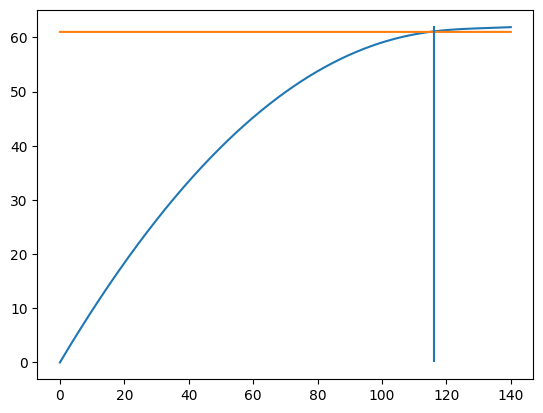

In [71]:
plt.plot(tR,np.log(af(tR)))
plt.plot(tR, 61*np.ones(tR.size))
plt.vlines(116,0, 62)


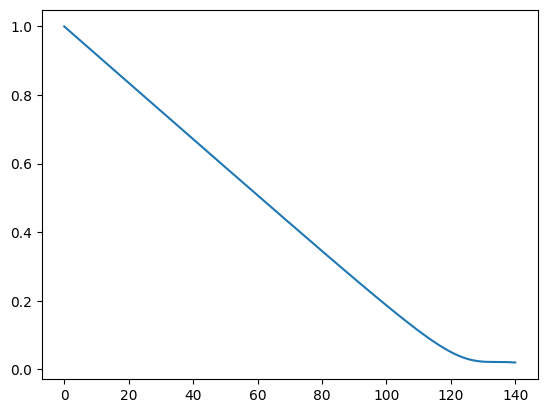

In [72]:
plt.plot(tR, HR)

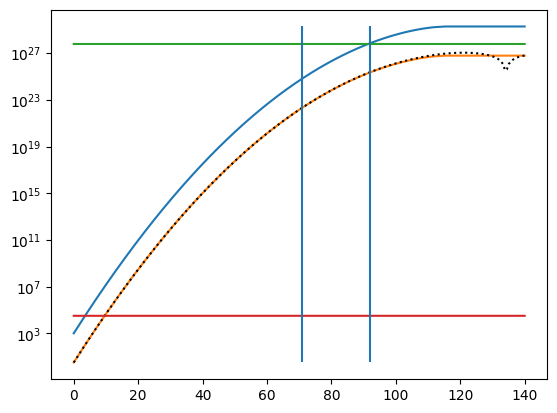

In [73]:
kh = khR

plt.plot(tR, kh*10**(5/2), label="kh*10^(5/2)")
plt.plot(tR, kh, label="kh")
plt.plot(tR, aR*abs(beta*dphidtR)/2 + aR*np.sqrt((beta*dphidtR)**2/4 + sigmaER**2/4 + sigmaER*HR/2), "k:")
plt.plot(tR, max(kh)*10*np.ones(len(tR)), label="kmax")
plt.plot(tR, min(kh)*10**4*np.ones(len(tR)))
plt.vlines(71, min(kh), 10**(5/2)*max(kh))
plt.vlines(92, min(kh), 10**(5/2)*max(kh))
plt.yscale("log")
plt.show()

In [81]:
omega = 3.814203717684728e-05
Ap1, dApdt1, Am1, dAmdt1, ks1, ts1 = ModeByMode(1., 71., tR[-1], khf, dphidtf, beta/Mpl, af,
                                              steps=200, cut = 0.01, sigmaE=sigmaEf, sigmaB=sigmaBf, delta=deltaf)
Ap2, dApdt2, Am2, dAmdt2, ks2, ts2 = ModeByMode(71., 94., tR[-1], khf, dphidtf, beta/Mpl, af,
                                                steps=800, cut = 0.01, sigmaE=sigmaEf, sigmaB=sigmaBf, delta=deltaf)

Elapsed time: 328.9497 seconds
Elapsed time: 2005.9159 seconds


In [82]:
print(len(Ap2))

799


In [83]:
SaveMode(ts1, ks1, Ap1, dApdt1, Am1, dAmdt1, af, name="ModesLow_SE_mix.dat")
SaveMode(ts2, ks2, Ap2, dApdt2, Am2, dAmdt2, af, name="ModesHigh_SE_mix.dat")

In [84]:
t1, N1, logk1, Ap1, dAp1, Am1, dAm1 = ReadModeFile(
    "ModesLow_SE_mix.dat")

t2, N2, logk2, Ap2, dAp2, Am2, dAm2 = ReadModeFile(
   "ModesHigh_SE_mix.dat")

In [85]:
Ap = np.array([*[CubicSpline(t1, Ap1[i,:])(t2) for i in range(len(logk1))], *list(Ap2)])
dAp = np.array([*[CubicSpline(t1, dAp1[i,:])(t2) for i in range(len(logk1))], *list(dAp2)])
Am = np.array([*[CubicSpline(t1, Am1[i,:])(t2) for i in range(len(logk1))], *list(Am2)])
dAm = np.array([*[CubicSpline(t1, dAm1[i,:])(t2) for i in range(len(logk1))], *list(dAm2)])

logk = np.array([*list(logk1), *list(logk2)])

print(logk.shape)

N = N2
t = t2



(998,)


In [86]:
EMode = []
BMode = []
GMode = []
#print(Ap[60,:])
#print(ts.size)
for i in range(len(t)):
    Etmp, Btmp, Gtmp = ComputeEBGnMode(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i],
                                       np.exp(N[i]), 10**logk, khf(t[i]), 0)
    EMode.append(Etmp)
    BMode.append(Btmp)
    GMode.append(Gtmp)
    
EMode1 = np.array(EMode)
BMode1 = np.array(BMode)
GMode1 = np.array(GMode)

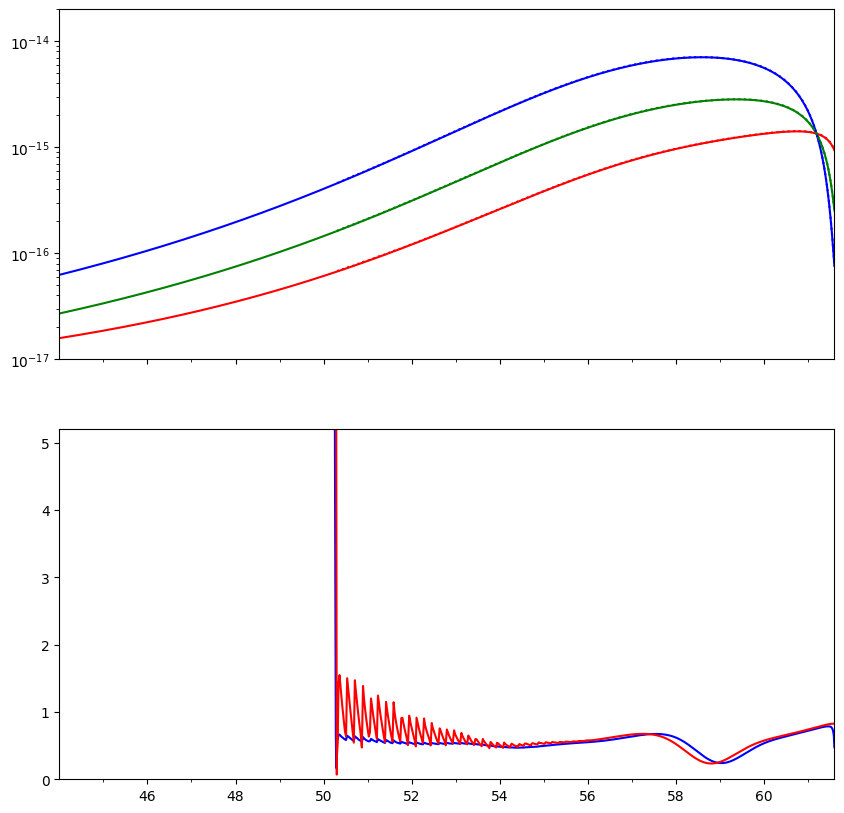

In [87]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)


rhoE = 0.5*ER*omega**4
errE = abs(ER - CubicSpline(N, EMode1)(NR))/CubicSpline(N, EMode1)(NR)
rhoB = 0.5*BR*omega**4
errB = abs(BR - CubicSpline(N, BMode1)(NR))/CubicSpline(N, BMode1)(NR)
rhoG = 0.5*abs(GR)*omega**4
errG = (abs(GR) - CubicSpline(N, abs(GMode1))(NR))/CubicSpline(N, abs(GMode1))(NR)

xticks = np.arange(46, 61, 2)
xticksmin = np.arange(45, 62, 2)
yticks = 10**(-1.*np.arange(14, 17))

ax[0].plot(NR, rhoE, "b", label=r"$\rho_E$")
ax[0].plot(NR, rhoB, "r", label=r"$\rho_B$")
ax[0].plot(NR, rhoG, "g", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|$")
ax[0].plot(N, 0.5*EMode1*omega**4, "b:", label=r"$\rho_E$")
ax[0].plot(N, 0.5*BMode1*omega**4, "r:", label=r"$\rho_B$")
ax[0].plot(N, 0.5*abs(GMode1)*omega**4, "g:", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|$")
ax[0].set_ylim(1e-17, 2e-14)
ax[0].set_xlim(44, 61.6)
ax[0].set_xticks(xticks)
ax[0].set_xticks(xticksmin, minor=True)
ax[0].set_yticks(yticks)
ax[0].set_yscale("log")
ax[1].plot(NR, abs(errE*100), "b")
ax[1].plot(NR, abs(errB*100), "r")
#ax[1].plot(NR, errG, "g:")
ax[1].set_ylim(0., 5.2)
ax[1].set_yticks(np.array([0, 1, 2, 3, 4, 5]))

/tmp/ipykernel_104517/2208613008.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(Nref, abs(spl(Nref)/Yref-1), col)


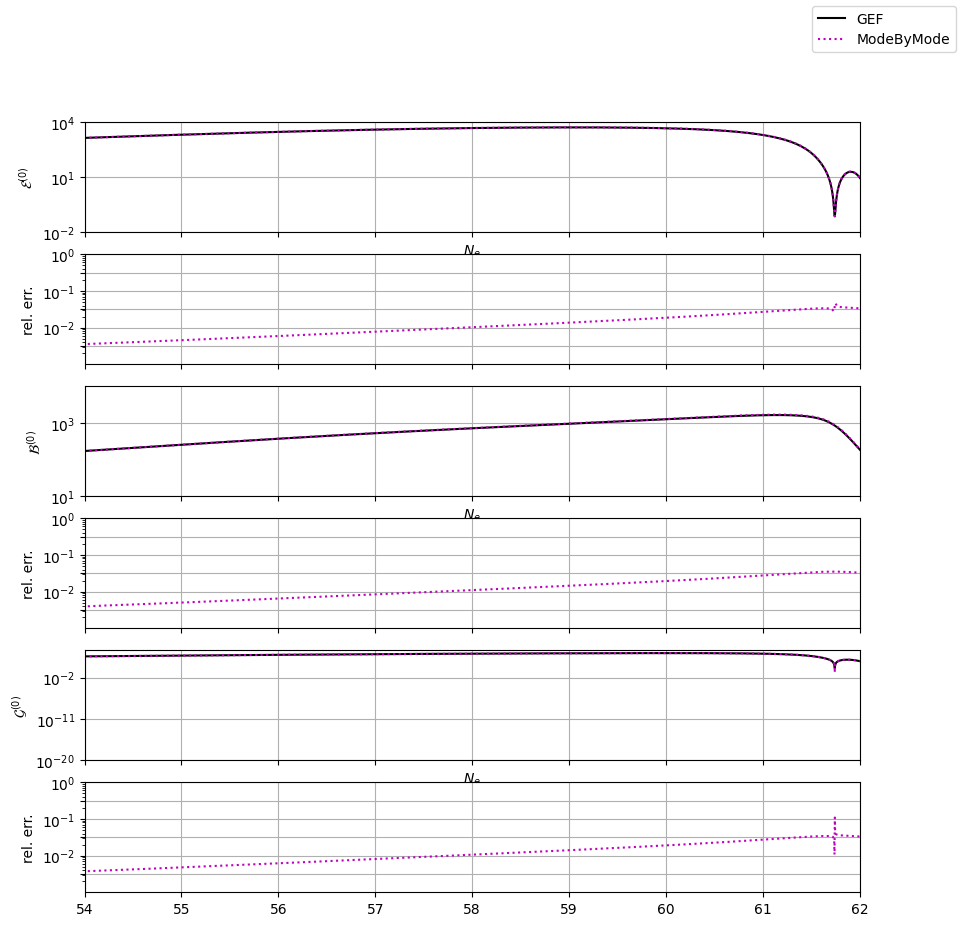

In [147]:
fig, ax = plt.subplots(6,1, figsize=(10,10), sharex=True)

NR = np.log(af(tR))


ax[0].plot(NR, ER, "k-", label="GEF")
PlotComp(ax[0], ax[1], N, EMode1, NR, ER, col="m:", label="ModeByMode", interp="cubic")
#PlotComp(ax[0], ax[1], N, EMode2, NR, ER, col="c:", label="ModeByMode", interp="cubic")
ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\mathcal{E}^{(0)}$")

ax[2].plot(NR, BR, "k-", label="GEF")
PlotComp(ax[2], ax[3], N, BMode1, NR, BR, col="m:", label="ModeByMode", interp="cubic")
#PlotComp(ax[2], ax[3], N, BMode2, NR, BR, col="c:", label="ModeByMode", interp="cubic")
ax[2].set_yscale("log")
ax[2].set_ylabel(r"$\mathcal{B}^{(0)}$")

ax[4].plot(NR, abs(GR), "k-", label="GEF")
PlotComp(ax[4], ax[5], N, abs(GMode1), NR, abs(GR), col="m:", label="ModeByMode", interp="cubic")
#PlotComp(ax[4], ax[5], N, GMode2, NR, GR, col="c:", label="ModeByMode", interp="cubic")
ax[4].set_yscale("log")
ax[4].set_ylabel(r"$\mathcal{G}^{(0)}$")

lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(0, 3, 0.5)
for i in range(3):
    ax[2*i+1].set_ylim(10.**(-3), 10**(-0.5))
    ax[2*i+1].set_yticks(10.**(-a))

ax[0].set_ylim(1e-2, 1e4)
ax[2].set_ylim(1e1, 1e4)
ax[4].set_ylim(1e-20, 1e4)

for ax in fig.axes:
    ax.grid(True)
    ax.set_xlim(54, 62)
plt.show()

# Oridnary GEF

In [78]:
file = "GEF_Beta25_M6_16.dat"
input_df = pd.read_table(file, sep=",")
data = input_df.values
print(data.shape)
tR = data[:,1]
aR = data[:,2]
lnkhR = data[:,3]
dphidtR = data[:,4]
HR = data[:,5]
ER = data[:,6]
BR = data[:,7]
GR = data[:,8]

(3961, 9)


In [79]:
af = CubicSpline(tR, aR)
dphidtf = CubicSpline(tR, dphidtR)
khf = CubicSpline(tR, np.exp(lnkhR))
Hf = CubicSpline(tR, HR)

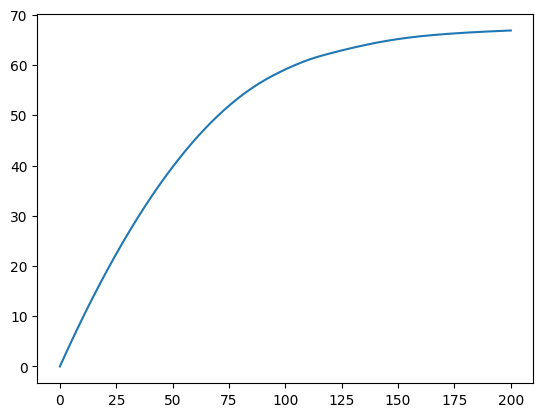

In [80]:
plt.plot(tR,np.log(aR))

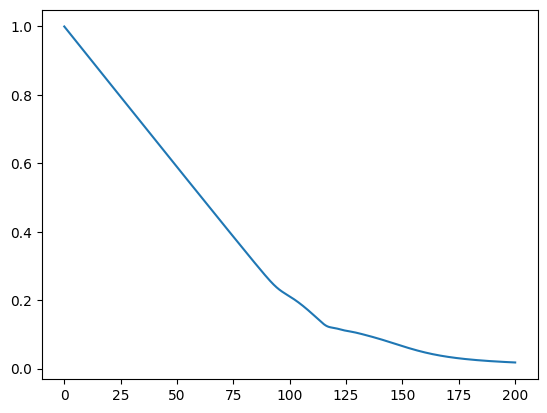

In [81]:
plt.plot(tR, HR)

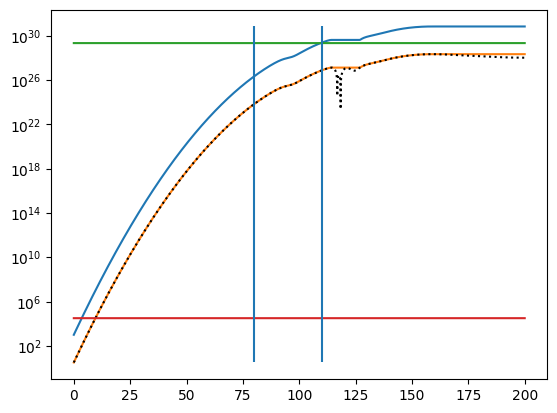

In [82]:
kh = np.exp(lnkhR)

plt.plot(tR, kh*10**(5/2), label="kh*10^(5/2)")
plt.plot(tR, kh, label="kh")
plt.plot(tR, aR*beta*abs(dphidtR), "k:")
plt.plot(tR, max(kh)*10*np.ones(len(tR)), label="kmax")
plt.plot(tR, min(kh)*10**4*np.ones(len(tR)))
plt.vlines(80, min(kh), 10**(5/2)*max(kh))
plt.vlines(110, min(kh), 10**(5/2)*max(kh))
plt.yscale("log")
plt.show()

In [83]:
omega = 3.915915816822987e-05
Ap1, dApdt1, Am1, dAmdt1, ks1, ts1 = ModeByMode(1., 71., tR[-1], khf, dphidtf, beta/Mpl, af,
                                                steps=200, cut = 0.01)
Ap2, dApdt2, Am2, dAmdt2, ks2, ts2 = ModeByMode(71., 110., tR[-1], khf, dphidtf, beta/Mpl, af, steps=800,
                                                cut = 0.01)

Elapsed time: 157.2390 seconds
Elapsed time: 1423.0689 seconds


In [84]:
print(len(Ap2))

799


In [85]:
SaveMode(ts1, ks1, Ap1, dApdt1, Am1, dAmdt1, af, name="ModesLowTake3.dat")
SaveMode(ts2, ks2, Ap2, dApdt2, Am2, dAmdt2, af, name="ModesHighTake3.dat")

In [86]:
t1, N1, logk1, Ap1, dAp1, Am1, dAm1 = ReadModeFile("ModesLowTake3.dat")

t2, N2, logk2, Ap2, dAp2, Am2, dAm2 = ReadModeFile("ModesHighTake3.dat")

In [87]:
Ap = np.array([*[CubicSpline(t1, Ap1[i,:])(t2) for i in range(len(logk1))], *list(Ap2)])
dAp = np.array([*[CubicSpline(t1, dAp1[i,:])(t2) for i in range(len(logk1))], *list(dAp2)])
Am = np.array([*[CubicSpline(t1, Am1[i,:])(t2) for i in range(len(logk1))], *list(Am2)])
dAm = np.array([*[CubicSpline(t1, dAm1[i,:])(t2) for i in range(len(logk1))], *list(dAm2)])

logk = np.array([*list(logk1), *list(logk2)])

print(logk.shape)

N = N2
t = t2



(998,)


In [88]:
EMode = []
BMode = []
GMode = []
#print(Ap[60,:])
#print(ts.size)
for i in range(len(t)):
    Etmp, Btmp, Gtmp = ComputeEBGnMode(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i],
                                       np.exp(N[i]), 10**logk, khf(t[i]), 0)
    EMode.append(Etmp)
    BMode.append(Btmp)
    GMode.append(Gtmp)
    
EMode2 = np.array(EMode)
BMode2 = np.array(BMode)
GMode2 = np.array(GMode)

/tmp/ipykernel_23577/2208613008.py:6: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(Nref, abs(spl(Nref)/Yref-1), col)


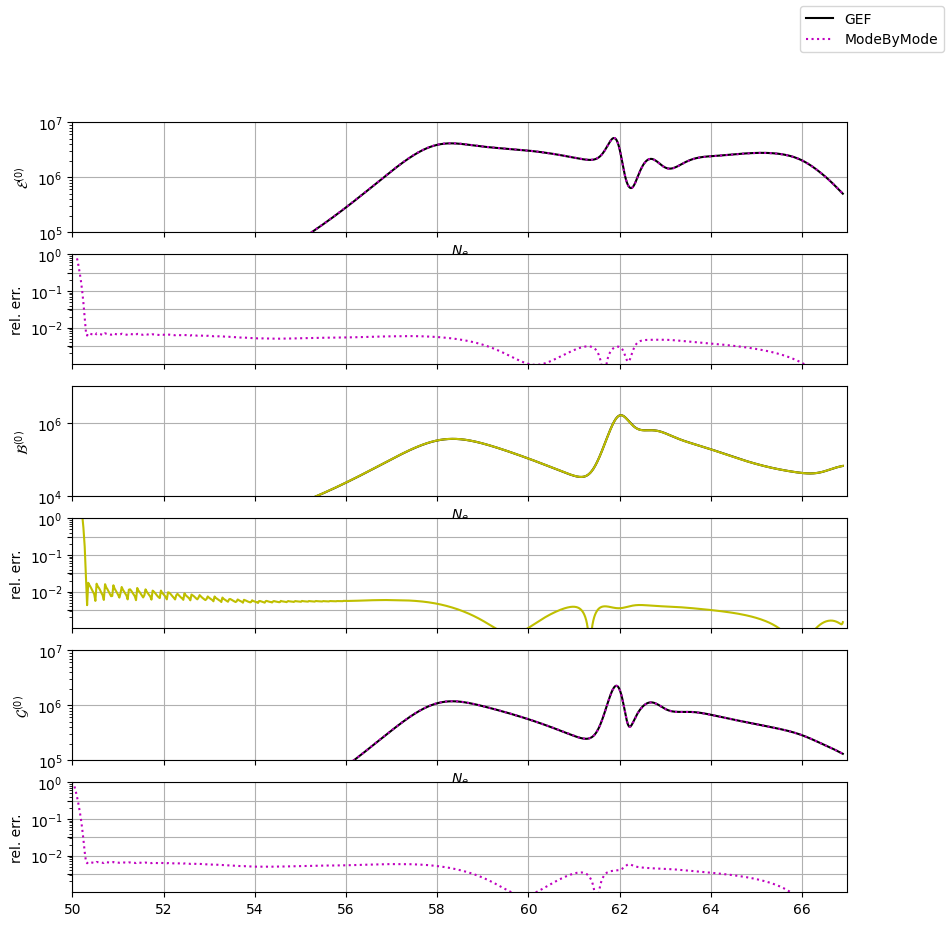

In [97]:
fig, ax = plt.subplots(6,1, figsize=(10,10), sharex=True)

NR = np.log(af(tR))


ax[0].plot(NR, ER, "k-", label="GEF")
PlotComp(ax[0], ax[1], N2, EMode2, NR, ER, col="m:", label="ModeByMode", interp="cubic")
#PlotComp(ax[0], ax[1], N, EMode2, NR, ER, col="c:", label="ModeByMode", interp="cubic")
ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\mathcal{E}^{(0)}$")

ax[2].plot(NR, BR, "k-", label="GEF")
PlotComp(ax[2], ax[3], N2, BMode2, NR, BR, col="y-", label="ModeByMode", interp="cubic")
#PlotComp(ax[2], ax[3], N, BMode2, NR, BR, col="c:", label="ModeByMode", interp="cubic")
ax[2].set_yscale("log")
ax[2].set_ylabel(r"$\mathcal{B}^{(0)}$")

ax[4].plot(NR, GR, "k-", label="GEF")
PlotComp(ax[4], ax[5], N2, GMode2, NR, GR, col="m:", label="ModeByMode", interp="cubic")
#PlotComp(ax[4], ax[5], N, GMode2, NR, GR, col="c:", label="ModeByMode", interp="cubic")
ax[4].set_yscale("log")
ax[4].set_ylabel(r"$\mathcal{G}^{(0)}$")

lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(0, 3, 0.5)
for i in range(3):
    ax[2*i+1].set_ylim(10.**(-3), 10**0)
    ax[2*i+1].set_yticks(10.**(-a))

ax[0].set_ylim(1e5, 1e7)
ax[2].set_ylim(1e4, 1e7)
ax[4].set_ylim(1e5, 1e7)

for ax in fig.axes:
    ax.grid(True)
    ax.set_xlim(50, 67)
plt.show()

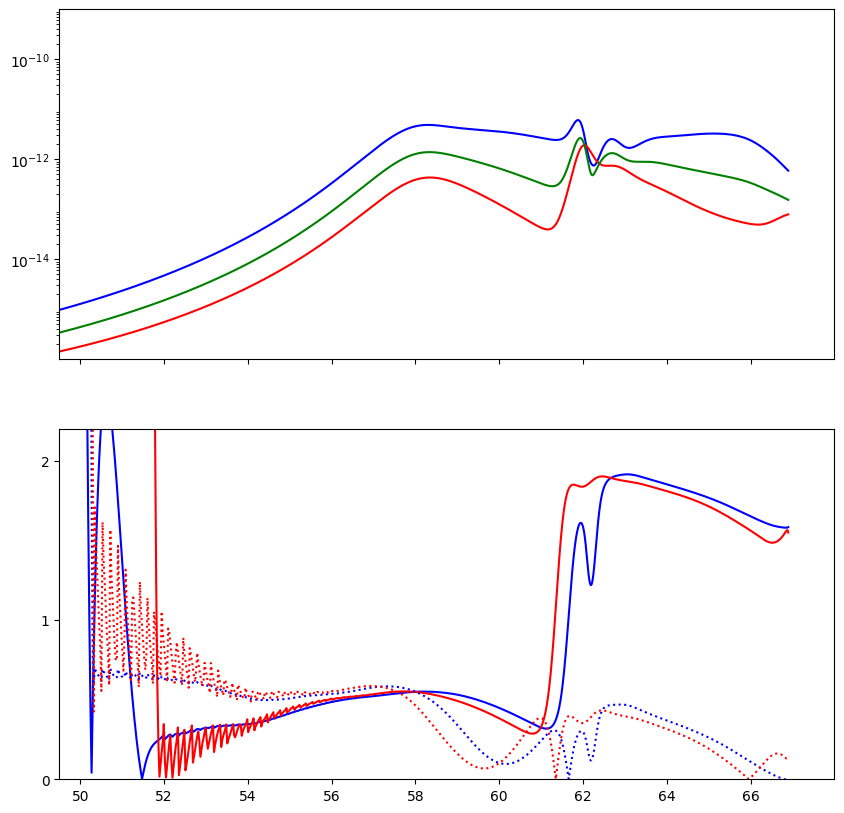

In [98]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)

rhoE = 0.5*ER*omega**4
errE = abs(ER - CubicSpline(N2a, EMode1)(NR))/CubicSpline(N2a, EMode1)(NR)
rhoB = 0.5*BR*omega**4
errB = abs(BR - CubicSpline(N2a, BMode1)(NR))/CubicSpline(N2a, BMode1)(NR)
rhoG = 0.5*abs(GR)*omega**4
#errG = (abs(GR) - CubicSpline(N2, abs(GMode1))(NR))/CubicSpline(N2, abs(GMode1))(NR)
errE2 = abs(ER - CubicSpline(N, EMode2)(NR))/CubicSpline(N, EMode2)(NR)

errB2 = abs(BR - CubicSpline(N, BMode2)(NR))/CubicSpline(N, BMode2)(NR)

ax[0].plot(NR, rhoE, "b", label=r"$\rho_E$")
ax[0].plot(NR, rhoB, "r", label=r"$\rho_B$")
ax[0].plot(NR, rhoG, "g", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|$")
ax[0].set_ylim(1e-16, 1e-9)
ax[0].set_yscale("log")
ax[0].set_xlim(49.5, 68)
xticks = np.arange(50, 67, 2)
ax[0].set_xticks(xticks)
yticks = np.arange(10, 15, 2)
ax[0].set_yticks(10.**(-yticks))
ax[1].plot(NR, errE*100, "b")
ax[1].plot(NR, errB*100, "r")
ax[1].plot(NR, errE2*100, "b:")
ax[1].plot(NR, errB2*100, "r:")
#ax[1].plot(NR, errG, "g:")
ax[1].set_ylim(0., 2.2)
ax[1].set_yticks(np.array([0, 1, 2]))

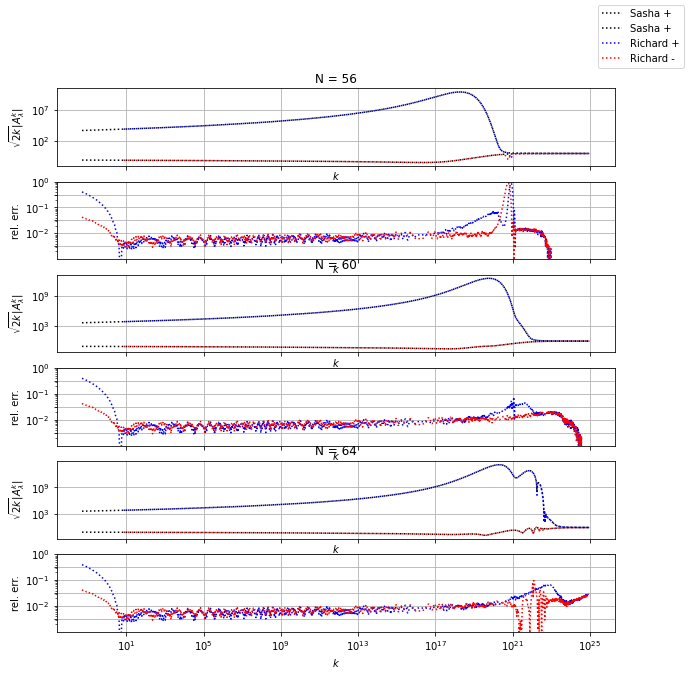

'plt.plot(k*omega, abs(Ap[:,n0])**2, label="|A^+_k|")\nplt.plot(k*omega, abs(Am[:,n0])**2, label="|A^-_k|")\nplt.plot(kO, ApO, "k:", label="Sasha Plus")\nplt.plot(kO, AmO, "k:",label="Sasha Minus")\nplt.xscale("log")\nplt.yscale("log")\nplt.legend(loc=0)\nplt.show()\n\nplt.plot(k*omega, abs(Ap[:,n0])**2, label="|A^+_k|")\nplt.plot(k*omega, abs(Am[:,n0])**2, label="|A^-_k|")\nplt.plot(kO, ApO, "k:", label="Sasha Plus")\nplt.plot(kO, AmO, "k:",label="Sasha Minus")\nplt.xscale("log")\nplt.yscale("log")\nplt.legend(loc=0)\nplt.show()'

In [21]:
omega = 3.915915816822987e-05
k = 10**(logk)

n0 = np.array([277, 668, 1377])
N0 = np.array([56, 60, 64])

fig, ax = plt.subplots(6,1, figsize=(10,10), sharex=True)

for i in range(3):
    file = ("/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/Sp_N"
            +str(N0[i]) + ".dat")
    input_df = pd.read_table(file, header=None)
    data = input_df.values
    kO = data[:,0]
    ApO = data[:,1]
    AmO = data[:,2]
    ax[2*i].set_title("N = " + str(N0[i]))
    ax[2*i].plot(kO, ApO, "k:", label="Sasha +")
    ax[2*i].plot(kO, AmO, "k:", label="Sasha +")
    PlotComp(ax[2*i], ax[2*i+1], k*omega, abs(Ap[:,n0[i]])**2, kO, ApO, col="b:", xax=r"$k$", label="Richard +", interp="cubic")
    PlotComp(ax[2*i], ax[2*i+1], k*omega, abs(Am[:,n0[i]])**2, kO, AmO, col="r:", xax=r"$k$", label="Richard -", interp="cubic")
    ax[2*i].set_yscale("log")
    ax[2*i].set_xscale("log")
    ax[2*i].set_ylabel(r"$\sqrt{2k}|A_\lambda^k|$")
    ax[2*i].set_xlabel(r"$k$")

lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(0, 3, 0.5)
for i in range(3):
    ax[2*i+1].set_ylim(10.**(-3), 10**0)
    ax[2*i+1].set_yticks(10.**(-a))

for ax in fig.axes:
    ax.grid(True)
plt.show()

"""plt.plot(k*omega, abs(Ap[:,n0])**2, label="|A^+_k|")
plt.plot(k*omega, abs(Am[:,n0])**2, label="|A^-_k|")
plt.plot(kO, ApO, "k:", label="Sasha Plus")
plt.plot(kO, AmO, "k:",label="Sasha Minus")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=0)
plt.show()

plt.plot(k*omega, abs(Ap[:,n0])**2, label="|A^+_k|")
plt.plot(k*omega, abs(Am[:,n0])**2, label="|A^-_k|")
plt.plot(kO, ApO, "k:", label="Sasha Plus")
plt.plot(kO, AmO, "k:",label="Sasha Minus")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=0)
plt.show()"""

In [17]:

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/mode_k1e3.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)
kO1 = 1e3
tO1 = data[:,0]
NO1 = data[:,1]
ApO1 = data[:,2]
AmO1 = data[:,3]
dApO1 = data[:,4]*(np.exp(NO1)/kO1)**2
dAmO1 = data[:,5]*(np.exp(NO1)/kO1)**2

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/mode_k1e12.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)
kO2 = 1e12
tO2 = data[:,0]
NO2 = data[:,1]
ApO2 = data[:,2]
AmO2 = data[:,3]
dApO2 = data[:,4]*(np.exp(NO2)/kO2)**2
dAmO2 = data[:,5]*(np.exp(NO2)/kO2)**2

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/mode_k1e21.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)
kO3 = 1e21
tO3 = data[:,0]
NO3 = data[:,1]
ApO3 = data[:,2]
AmO3 = data[:,3]
dApO3 = data[:,4]*(np.exp(NO3)/kO3)**2
dAmO3 = data[:,5]*(np.exp(NO3)/kO3)**2

(1951, 6)
(1728, 6)
(1400, 6)


In [22]:
print(logk1[15]+np.log10(omega))
print(logk1[89]+np.log10(omega))
print(logk1[197]+np.log10(omega))


3.001583396653322
12.071845184881827
21.02319239373236


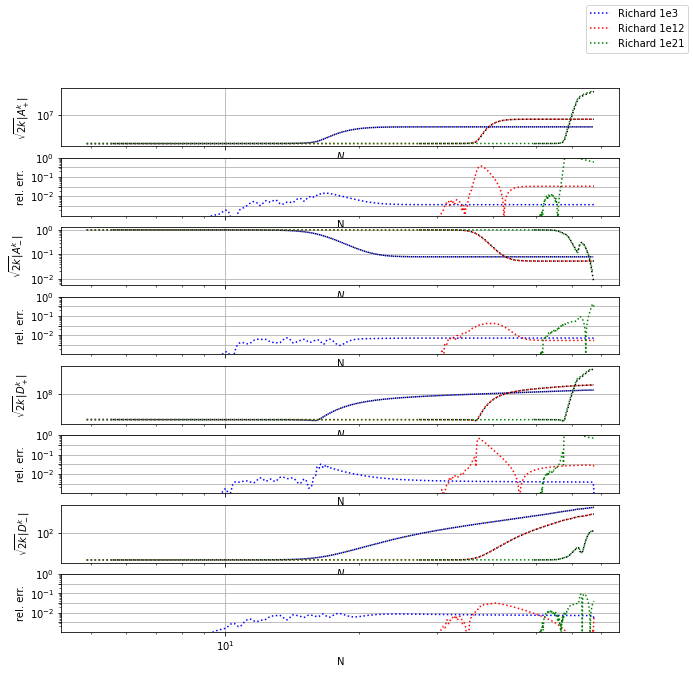

In [23]:
fig, ax = plt.subplots(8,1, figsize=(10,10), sharex=True)

ax[0].plot((NO1), ApO1, "k:")
ax[0].plot((NO2), ApO2, "k:")
ax[0].plot((NO3), ApO3, "k:")
PlotComp(ax[0], ax[1], N1, abs(Ap1[15,:])**2, NO1, ApO1, col="b:", xax="N", label="Richard 1e3", interp="cubic")
PlotComp(ax[0], ax[1], N1, abs(Ap1[88,:])**2, NO2, ApO2, col="r:", xax="N", label="Richard 1e12", interp="cubic")
PlotComp(ax[0], ax[1], N1, abs(Ap1[196,:])**2, NO3, ApO3, col="g:", xax="N", label="Richard 1e21", interp="cubic")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"$\sqrt{2k}|A_+^k|$")
ax[0].set_xlabel(r"$N$")

ax[2].plot((NO1), AmO1, "k:")
ax[2].plot((NO2), AmO2, "k:")
ax[2].plot((NO3), AmO3, "k:")
PlotComp(ax[2], ax[3], N1, abs(Am1[15,:])**2, NO1, AmO1, col="b:", xax="N", label="Richard 1e3", interp="cubic")
PlotComp(ax[2], ax[3], N1, abs(Am1[88,:])**2, NO2, AmO2, col="r:", xax="N", label="Richard 1e12", interp="cubic")
PlotComp(ax[2], ax[3], N1, abs(Am1[196,:])**2, NO3, AmO3, col="g:", xax="N", label="Richard 1e21", interp="cubic")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_ylabel(r"$\sqrt{2k}|A_-^k|$")
ax[2].set_xlabel(r"$N$")

ax[4].plot((NO1), dApO1, "k:")
ax[4].plot((NO2), dApO2, "k:")
ax[4].plot((NO3), dApO3, "k:")
PlotComp(ax[4], ax[5], N1, abs(dAp1[15,:])**2, NO1, dApO1, col="b:", xax="N", label="Richard 1e3", interp="cubic")
PlotComp(ax[4], ax[5], N1, abs(dAp1[88,:])**2, NO2, dApO2, col="r:", xax="N", label="Richard 1e12", interp="cubic")
PlotComp(ax[4], ax[5], N1, abs(dAp1[196,:])**2, NO3, dApO3, col="g:", xax="N", label="Richard 1e21", interp="cubic")
ax[4].set_yscale("log")
ax[4].set_xscale("log")
ax[4].set_ylabel(r"$\sqrt{2k}|D_+^k|$")
ax[4].set_xlabel(r"$N$")

ax[6].plot((NO1), dAmO1, "k:")
ax[6].plot((NO2), dAmO2, "k:")
ax[6].plot((NO3), dAmO3, "k:")
PlotComp(ax[6], ax[7], N1, abs(dAm1[15,:])**2, NO1, dAmO1, col="b:", xax="N", label="Richard 1e3", interp="cubic")
PlotComp(ax[6], ax[7], N1, abs(dAm1[88,:])**2, NO2, dAmO2, col="r:", xax="N", label="Richard 1e12", interp="cubic")
PlotComp(ax[6], ax[7], N1, abs(dAm1[196,:])**2, NO3, dAmO3, col="g:", xax="N", label="Richard 1e21", interp="cubic")
ax[6].set_yscale("log")
ax[6].set_xscale("log")
ax[6].set_ylabel(r"$\sqrt{2k}|D_-^k|$")
ax[6].set_xlabel(r"$N$")


lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

a = np.arange(0, 3, 0.5)
for i in range(4):
    ax[2*i+1].set_ylim(10.**(-3), 10**0)
    ax[2*i+1].set_yticks(10.**(-a))

for ax in fig.axes:
    ax.grid(True)
plt.show()

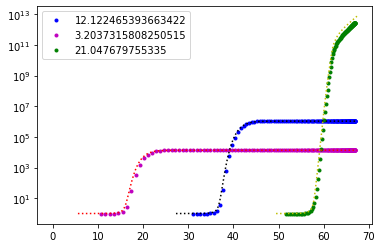

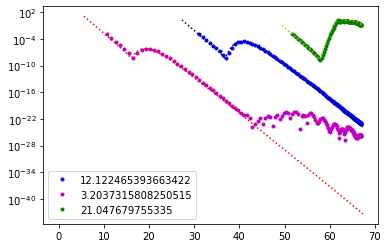

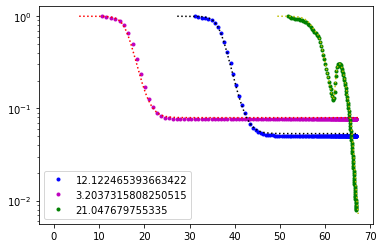

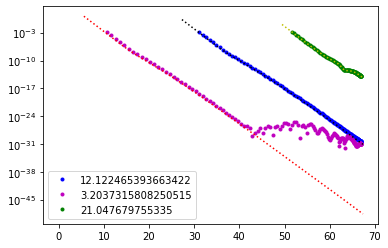

In [110]:
plt.plot(N, abs(np.array(Ap)[32,:])**2, "b.", label=str(np.log10(k[32]*omega)))
plt.plot(N, abs(np.array(Ap)[9,:])**2, "m.", label=str(np.log10(k[9]*omega)))
plt.plot(N, abs(np.array(Ap)[66,:])**2, "g.", label=str(np.log10(k[66]*omega)))
#plt.vlines(ts[71], 1., 1e17)
plt.plot((N1), Ap1, "r:")
plt.plot((N2), Ap2, "k:")
plt.plot((N3), Ap3, "y:")
plt.yscale("log")
plt.legend(loc=0)
plt.show()

plt.plot(N, abs(np.array(dApdt)[32,:])**2*omega**2, "b.", label=str(np.log10(omega*k[32])))
plt.plot(N, abs(np.array(dApdt)[9,:])**2*omega**2,"m.", label=str(np.log10(omega*k[9])))
plt.plot(N, abs(np.array(dApdt)[66,:])**2*omega**2,"g.", label=str(np.log10(omega*k[66])))
#plt.vlines(ts[71], 1., 1e17)
plt.plot((N1), dAp1, "r:")
plt.plot((N2), dAp2, "k:")
plt.plot((N3), dAp3, "y:")
plt.yscale("log")
plt.legend(loc=0)
plt.show()

plt.plot(N, abs(np.array(Am)[32,:])**2, "b.", label=str(np.log10(omega*k[32])))
plt.plot(N, abs(np.array(Am)[9,:])**2, "m.", label=str(np.log10(omega*k[9])))
plt.plot(N, abs(np.array(Am)[66,:])**2, "g.", label=str(np.log10(omega*k[66])))
#plt.vlines(ts[71], 1., 1e17)
plt.plot((N1), Am1, "r:")
plt.plot((N2), Am2, "k:")
plt.plot((N3), Am3, "y:")
plt.yscale("log")
plt.legend(loc=0)
plt.show()

plt.plot(N, abs(np.array(dAmdt)[32,:])**2*omega**2, "b.", label=str(np.log10(omega*k[32])))
plt.plot(N, abs(np.array(dAmdt)[9,:])**2*omega**2,"m.", label=str(np.log10(omega*k[9])))
plt.plot(N, abs(np.array(dAmdt)[66,:])**2*omega**2,"g.", label=str(np.log10(omega*k[66])))
#plt.vlines(ts[71], 1., 1e17)
plt.plot((N1), dAm1, "r:")
plt.plot((N2), dAm2, "k:")
plt.plot((N3), dAm3, "y:")
plt.yscale("log")
plt.legend(loc=0)
plt.show()

In [18]:
comp1 = []
comp2 = []
comp3 = []
comp4 = []
for i in range(len(k)):
    comp1.append(abs(np.array(Ap)[i,i+2])/abs(np.array(Ap)[i,i+1]))
    comp2.append(abs(np.array(dApdt)[i,i+2])/abs(np.array(dApdt)[i,i+1]))
    comp3.append(abs(np.array(Am)[i,i+2])/abs(np.array(Ap)[i,i+1]))
    comp4.append(abs(np.array(dAmdt)[i,i+2])/abs(np.array(dApdt)[i,i+1]))

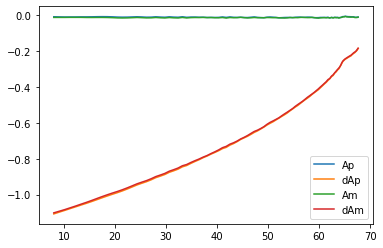

In [19]:
plt.plot(np.log(k), np.log(comp1), label="Ap")
plt.plot(np.log(k), np.log(comp2), label="dAp")
plt.plot(np.log(k), np.log(comp3), label="Am")
plt.plot(np.log(k), np.log(comp4), label="dAm") 
plt.legend(loc=0)
plt.show()

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'float'

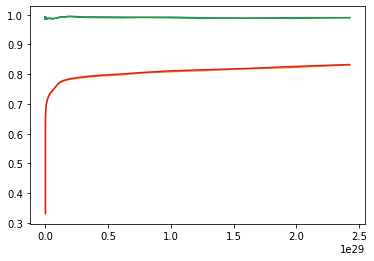

In [20]:
plt.plot(k, comp1, label="Ap")
plt.plot(k, comp2, label="dAp")
plt.plot(k, comp3, label="Am")
plt.plot(k, comp4, label="dAm") 
plt.plot(k, np.exp(-14.25)*k**(1/2) )
plt.legend(loc=0)
plt.show()
print(np.exp(-14.25)**2)

In [21]:
print(np.sqrt(2*k[66])*np.array(Ap)[66,68])
print(np.sqrt(2*k[66])*np.array(Ap)[66,67])
print(2*k[66]*abs(np.array(Ap)[66,68])**2)

(-5.889344094314069e+12-4586873234185.81j)
(7549847894313.993+0j)
5.572377992772218e+25


In [131]:
print(abs(np.array(Ap)[9,11])**2/abs(np.array(Ap)[9,10])**2, k[9])
print(abs(np.array(Ap)[29,31])**2/abs(np.array(Ap)[29,30])**2, np.sqrt(k[29]))
print(abs(np.array(Ap)[66,68])/abs(np.array(Ap)[66,67]), np.sqrt(k[66]))

0.9853245161149857 40822371.808270566
0.9829221719474981 56131845.49006122
0.9891061668698059 5338548642996.411


In [ ]:

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/Sp_N60.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)
kO = data[:,0]
ApO = data[:,1]
AmO = data[:,2]

n0 = 94

plt.plot(k*omega, 2*k*abs(np.array(Ap)[:,n0])**2, label="|A^+_k|")
plt.plot(k*omega, 2*k*abs(np.array(Am)[:,n0])**2, label="|A^-_k|")
plt.vlines(khf(ts[n0])*omega, min(2*k*abs(np.array(Am)[:,n0])**2), max(2*k*abs(np.array(Ap)[:,n0])**2))
plt.vlines(10**(5/2)*khf(110)*omega, min(2*k*abs(np.array(Am)[:,n0])**2),
           max(2*k*abs(np.array(Ap)[:,n0])**2)) 
plt.vlines(10**(5/2)*khf(ts[0])*omega, min(2*k*abs(np.array(Am)[:,n0])**2),
           max(2*k*abs(np.array(Ap)[:,n0])**2)) 
plt.plot(kO, ApO, label="Sasha Plus")
plt.plot(kO, AmO, label="Sasha Minus")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=0)
plt.show()
#print(ts[600])
#print(np.log(af(ts[657])))
print(np.log(af(ts[n0])))

In [ ]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Comparision/Sp_N56.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)
kO = data[:,0]
ApO = data[:,1]
AmO = data[:,2]

n0 = 77

plt.plot(k*omega, 2*k*abs(np.array(Ap)[:,n0])**2, label="|A^+_k|")
plt.plot(k*omega, 2*k*abs(np.array(Am)[:,n0])**2, label="|A^-_k|")
plt.vlines(khf(ts[n0])*omega, min(2*k*abs(np.array(Am)[:,n0])**2), max(2*k*abs(np.array(Ap)[:,n0])**2))
plt.vlines(10**(5/2)*khf(110)*omega, min(2*k*abs(np.array(Am)[:,n0])**2),
           max(2*k*abs(np.array(Ap)[:,n0])**2)) 
plt.vlines(10**(5/2)*khf(ts[0])*omega, min(2*k*abs(np.array(Am)[:,n0])**2),
           max(2*k*abs(np.array(Ap)[:,n0])**2)) 
plt.plot(kO, ApO, label="Sasha Plus")
plt.plot(kO, AmO, label="Sasha Minus")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=0)
plt.show()
#print(ts[600])
#print(np.log(af(ts[657])))
print(np.log(af(ts[n0])))

In [34]:
logk = np.log10(ks)
dicAP = {"N":np.array([np.nan]+list(np.log(af(ts))))}
for k in range(0, len(Ap[:,0])):
    dictmp = {"Ap_" + str(k) :np.array([logk[k]] + Ap[k,:])}
    dicAP = dict(dicAP, **dictmp)
    
filename = "ModesAp.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(dicAP)  
output_df.to_csv(path)

dicAm = {"Am_0":Am[0,:]}
for k in range(1, len(Am[:,0])):
    dictmp = {"Am_" + str(k) : Am[k,:]}
    dicAm = dict(dicAm, **dictmp)
    
filename = "ModesAm.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(dicAm)  
output_df.to_csv(path)

dicdAp = {"dAp_0":dAp[0,:]}
for k in range(1,len(dAp[:,0])):
    dictmp = {"dAp_" + str(k) : dAp[k,:]}
    dicdAp = dict(dicdAp, **dictmp)
    
filename = "ModesdAp.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(dicdAp)  
output_df.to_csv(path)

dicdAm = {"dAm_0":dAm[0,:]}
for k in range(1, len(k)):
    dictmp = {"dAm_" + str(k) : dAm[k,:]}
    dicdAm = dict(dicdAm, **dictmp)
    
filename = "ModesdAm.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(dicdAm)  
output_df.to_csv(path)


TypeError: object of type 'int' has no len()

In [72]:

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/ModesAp.dat"
input_df = pd.read_table(file, sep=",")
dataAp = input_df.values
print(dataAp.shape)

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/ModesdAp.dat"
input_df = pd.read_table(file, sep=",")
datadAp = input_df.values
print(datadAp.shape)

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/ModesAm.dat"
input_df = pd.read_table(file, sep=",")
dataAm = input_df.values
print(dataAm.shape)

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/ModesdAm.dat"
input_df = pd.read_table(file, sep=",")
datadAm = input_df.values
print(datadAm.shape)




(100, 101)
(100, 101)
(100, 101)
(100, 101)


In [73]:
data = np.array([dataAp[:,1:].T, datadAp[:,1:].T, dataAm[:,1:].T, datadAm[:,1:].T])
print(data.shape)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
print(data.shape)

print(datadAp[130,42])
print(data[141,130])

(4, 100, 100)
(400, 100)


IndexError: index 130 is out of bounds for axis 0 with size 100

In [68]:

names = ["AP_"+str(k) for k in range(knum)]
names = [*names, *["dAP_"+str(k) for k in range(knum)]]
names = [*names, *["AM_"+str(k) for k in range(knum)]]
names = [*names, *["dAM_"+str(k) for k in range(knum)]]

DataDic = dict(zip(names, data))

print(DataDic.get("dAP_130")[41])

filename = "Modes.dat"

DirName = os.getcwd()

path = os.path.join(DirName, filename)

output_df = pd.DataFrame(DataDic)  
output_df.to_csv(path)

TypeError: 'NoneType' object is not subscriptable

In [66]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Modes.dat"
input_df = pd.read_table(file, sep=",")
data = input_df.values[:,1:]
print(data.shape)

data = data.reshape(data.shape[0], int(data.shape[1]/4), 4)
print(data[130, 41, 1])
Ap = np.array([[complex(data[k, t, 0]) for t in range(data.shape[1])] for k in range(data.shape[0])])
dAp = np.array([[complex(data[k, t, 1]) for t in range(data.shape[1])] for k in range(data.shape[0])])
Am = np.array([[complex(data[k, t, 2]) for t in range(data.shape[1])] for k in range(data.shape[0])])
dAm = np.array([[complex(data[k, t, 3]) for t in range(data.shape[1])] for k in range(data.shape[0])])

print(dAp[130, 43])

(200, 400)
(-2.923672477697672e-05-0.0001221473699965777j)
(-0.00010861413944259197+8.195469820734275e-05j)


In [108]:
x = [1,2,3]
y = [4,5,6]
z = [*x, *y]
print(z)

[1, 2, 3, 4, 5, 6]


In [17]:
print(np.arange(3,10, 4))

[3 7]


In [5]:
def ModeEoM2(A, k, dphidt, dIdphi, a, H, sigma=0):
    dAdt = np.zeros(A.size)
    #print("a:", a)
    #print("H:", H)
    #print("dphidt:", dphidt)
    """print(k)
    print(a)
    print(k/a)
    """
    drag = ((1.-alpha)*H + a**alpha*sigma)
    dis1 = (k/a)**2 * a**(2*alpha)
    dis2 = (k/a)*dIdphi *a**alpha * dphidt
    #print("dis:",dis1, dis2, dis1-dis2)
    #positive helicity
    lam = 1.
    #Real Part
    dAdt[0] = A[1]
    dAdt[1] = -( drag * A[1] + (dis1  - lam * dis2) * A[0] )
    
    #Imaginary Part
    dAdt[2] = A[3]
    dAdt[3] = -( drag * A[3] + (dis1  - lam * dis2) * A[2] )
    
    
    #negative helicity
    lam = -1.
    #Real Part
    dAdt[4] = A[5]
    dAdt[5] = -( drag * A[5] + (dis1  - lam * dis2) * A[4] )
    
    #Imaginary Part
    dAdt[6] = A[7]
    dAdt[7] = -( drag * A[7] + (dis1  - lam * dis2) * A[6] )
    """print(np.sqrt(2*k)*A)
    print(np.sqrt(2*k)*dAdt)"""
    #print(dis1-dis2, drag, dis1-dis2, drag, dis1+dis2, drag, dis1+dis2, drag)
    
    return dAdt

In [6]:
def InitialiseMode(k, a):
    ARe = 1. # *np.exp(-z*1j)
    dAdtIm = -k/a # *np.exp(-z*1j)
    return ARe, dAdtIm

In [7]:
def ModeByMode2(tmin, tmax, tend, kh, dphidt, dIdphi, a, H, steps=100, cut=0.1, sigma=0, save=False):
    dt = (tmax-tmin)/(steps-1)
    ts = np.arange(tmin, tend+dt, dt)
    print(len(ts))

    Ap = []
    dApdt = []
    Am = []
    dAmdt = []
    ks = []
    t2 = Timer()
    t2.start()
    for i in range(1,steps):
        s = ts[i]
        if (kh(s)/kh(ts[i-1]) > cut): 
            k = 10**(5/2)*kh(s)
            #print(np.log10(k))
            """print("step:", i)
            print("mode:", k)"""
            t1 = Timer()
            ks.append(k)
            Avac, dAvacdt = InitialiseMode(k, a(s))

            t1.start()
            Aini = np.array([Avac, 0, 0, dAvacdt, Avac, 0, 0, dAvacdt])
            ode = lambda x, y: ModeEoM2(y, k, dphidt(x), dIdphi, a(x), H(x))
            
            sol = solve_ivp(ode, [ts[i], ts[-1]], Aini, t_eval=ts[i:], method="RK45")
            print(len(ts[i:]))
            
            #vacuum will not contribute to integrals, so we set this part to 0 to have equal length arrays
            vac = list((1+1j)*np.zeros((i)))
            print(len(vac))
            Aptmp = list(np.array(sol.y[0,:]) + np.array(sol.y[2,:])*1j)
            Ap.append([*vac, *Aptmp])
            
            dAptmp = list(np.array(sol.y[1,:]) + np.array(sol.y[3,:])*1j)
            dApdt.append([*vac, *dAptmp])
            
            
            Amtmp = list(np.array(sol.y[4,:]) + np.array(sol.y[6,:])*1j)
            Am.append([*vac, *Amtmp])
            
            dAmtmp = list(np.array(sol.y[5,:]) + np.array(sol.y[7,:])*1j)
            dAmdt.append([*vac, *dAmtmp])
            print(len(dAmdt))
            t1.stop()
        else:
            print("skip")
            continue
            
    #Ap = np.array(Ap)
    #dApdt = np.array(dApdt)            
    #Am = np.array(Am)
    #dAmdt = np.array(dAmdt)
    
    t2.stop()
    
    if save:
        SaveMode(ts, ks, Ap, dApdt, Am, dAmdt, af)
                   
    
    return Ap, dApdt, Am, dAmdt, ks, ts